In [1]:
# Pacotes

# Manipulação de dados em DataFrames
import pandas as pd

# Visualização gráfica
import matplotlib.pyplot as plt

# Criação de objetos de linha e pontos
from shapely.geometry import LineString
from shapely.geometry import Point

# Manipulação de dados espaciais (GeoDataFrames)
import geopandas as gpd

# Conversão entre WKT (texto) e objetos geométricos
from shapely import wkt

# Transformação de sistemas de coordenadas
from pyproj import Transformer

# Obtenção de dados geográficos da OpenStreetMap
import osmnx as ox

In [2]:
# Bancos de dados
oss = r'C:\Users\amand\Amanda\Doutorado\Artigo indicadores OSS\Coordenadas 2025\oss_bhviva_magalhaes_29.08.2025.dta'
virtual_completo = r'C:\Users\amand\Amanda\Analises\Auditoria Virtual\Auditoria Virtual Amostra Total - 27 cidades.dta'

# Leitura dos arquivos .dta como DataFrames
oss = pd.read_stata(oss)
virtual_completo = pd.read_stata(virtual_completo)

# Verificar número de linhas e colunas de cada base
print(oss.shape)
print(virtual_completo.shape)

C:\Users\amand\AppData\Local\Temp\ipykernel_25876\1189150900.py:6: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  oss = pd.read_stata(oss)


(373, 690)
(2639, 221)


In [3]:
# Dados da auditoria virtual apenas para Belo Horizonte (a OSS só foi coletada em Belo Horizonte, não é necessário filtrar)

virtual = virtual_completo[virtual_completo['cidade'] == 'Belo Horizonte']
virtual.shape

(165, 221)

In [4]:
# Manter apenas as variáveis de interesse

oss = oss[['setor', 'vila_entorno', 'data_obs_1', 'X_inicio', 'Y_inicio', 'X_final', 'Y_final']]

virtual = virtual[['identificador', 'data_imagens', 'wkt', 'coordenadas_inicio', 'coordenadas_termino', 'coordenadas_inicio_2', 'coordenadas_termino_2']]

print(oss.shape)
print(virtual.shape)

(373, 7)
(165, 7)


In [5]:
# Coordenadas OSS

# 1. Criar colunas de coordenadas como tupla
oss['X_Y_inicio'] = list(zip(oss['X_inicio'], oss['Y_inicio']))
oss['X_Y_termino'] = list(zip(oss['X_final'], oss['Y_final']))

# 2. Definir transformador UTM para WGS 84 (assumindo UTM zona 23S - EPSG:31983)
transformer = Transformer.from_crs("EPSG:31983", "EPSG:4326", always_xy=True)

# 3. Função de conversão
def converter_utm_para_latlon(coordenada):
    if coordenada is None or coordenada == (None, None):
        return (None, None)
    x, y = coordenada
    lon, lat = transformer.transform(x, y)
    return (lat, lon)

# 4. Aplicar conversão
oss['coordenadas_inicio'] = oss['X_Y_inicio'].apply(converter_utm_para_latlon)
oss['coordenadas_termino'] = oss['X_Y_termino'].apply(converter_utm_para_latlon)

# 5. Transformar em string no formato "lat, lon"
oss['coordenadas_inicio'] = oss['coordenadas_inicio'].apply(
    lambda coord: f"{coord[0]:.6f}, {coord[1]:.6f}" if coord != (None, None) else None)
oss['coordenadas_termino'] = oss['coordenadas_termino'].apply(
    lambda coord: f"{coord[0]:.6f}, {coord[1]:.6f}" if coord != (None, None) else None)

# 6. Excluir coordenadas ausentes (n=3)
oss = oss[~((oss['coordenadas_inicio'] == 'nan, nan') & (oss['coordenadas_termino'] == 'nan, nan'))]

oss.shape

(370, 11)

In [6]:
# Organizar variáveis OSS

oss = oss.rename(columns={'setor': 'id'})
oss['id'] = oss['id'].str.replace('-', '', regex=False)

oss = oss.rename(columns={'vila_entorno': 'area'})

oss = oss.rename(columns={'data_obs_1': 'data'})
oss['data'] = pd.to_datetime(oss['data'], dayfirst=True, errors='coerce')

oss.insert(oss.columns.get_loc("coordenadas_inicio"), "field", "oss")

oss = oss.drop(columns=[col for col in ['X_inicio', 'Y_inicio', 'X_final', 'Y_final', 'X_Y_inicio', 'X_Y_termino'] if col in oss.columns])

oss.shape

(370, 6)

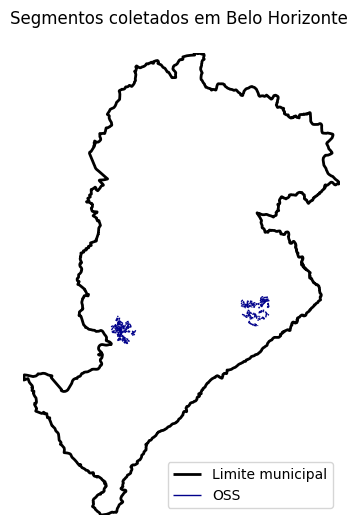

In [7]:
# Plot OSS

def string_to_point(coord_str):
    if coord_str is None or pd.isna(coord_str):
        return None
    lat_str, lon_str = coord_str.split(", ")
    return float(lon_str), float(lat_str)

def string_to_linestring(row):
    start = string_to_point(row['coordenadas_inicio'])
    end = string_to_point(row['coordenadas_termino'])
    if start is None or end is None:
        return None
    return LineString([start, end])

oss['geometry'] = oss.apply(string_to_linestring, axis=1)

gdf_oss = gpd.GeoDataFrame(oss, geometry='geometry', crs="EPSG:4326")

gdf_bh = ox.geocode_to_gdf("Belo Horizonte, Brazil")

fig, ax = plt.subplots(figsize=(5, 6))

gdf_bh.boundary.plot(ax=ax, edgecolor='black', linewidth=2, label="Limite municipal")

gdf_oss.plot(ax=ax, color='darkblue', linewidth=1, alpha=1, label="OSS")

xmin, ymin, xmax, ymax = gdf_bh.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_title("Segmentos coletados em Belo Horizonte \n", fontsize=12)
ax.axis("off")

ax.legend(loc="lower right")

plt.show()

In [8]:
# Organizar variáveis auditoria virtual

virtual = virtual.rename(columns={'identificador': 'id'})
virtual = virtual.rename(columns={'data_imagens': 'data'})

virtual['id'] = virtual['id'].astype(str)
virtual["id"] = virtual["id"].astype(str).str.replace(r"\.0$", "", regex=True)


def move_column(df, col_to_move, after_col):
    cols = list(df.columns)
    cols.remove(col_to_move)
    insert_at = cols.index(after_col) + 1
    cols.insert(insert_at, col_to_move)
    return df[cols]
virtual = move_column(virtual, "wkt", "coordenadas_termino_2")

virtual.insert(virtual.columns.get_loc("coordenadas_inicio"), "field", "virtual")

virtual.shape

(165, 8)

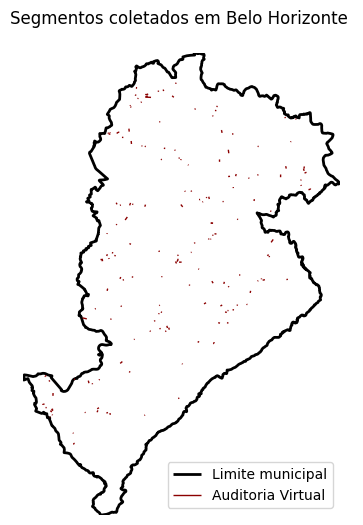

In [9]:
# Plot auditoria virtual

def string_to_point(coord_str):
    if coord_str is None or pd.isna(coord_str):
        return None
    lat_str, lon_str = coord_str.split(", ")
    return float(lon_str), float(lat_str)

def string_to_linestring(row):
    start = string_to_point(row['coordenadas_inicio'])
    end = string_to_point(row['coordenadas_termino'])
    if start is None or end is None:
        return None
    return LineString([start, end])

virtual['geometry'] = virtual['wkt'].apply(wkt.loads)

gdf_virtual = gpd.GeoDataFrame(virtual, geometry='geometry', crs="EPSG:4326")

gdf_bh = ox.geocode_to_gdf("Belo Horizonte, Brazil")

fig, ax = plt.subplots(figsize=(5, 6))

gdf_bh.boundary.plot(ax=ax, edgecolor='black', linewidth=2, label="Limite municipal")

gdf_virtual.plot(ax=ax, color='darkred', linewidth=1, alpha=1, label="Auditoria Virtual")

xmin, ymin, xmax, ymax = gdf_bh.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_title("Segmentos coletados em Belo Horizonte \n", fontsize=12)
ax.axis("off")

ax.legend(loc="lower right")

plt.show()

In [10]:
# Append oss e auditoria virtual

df = pd.concat([oss, virtual], ignore_index=True)

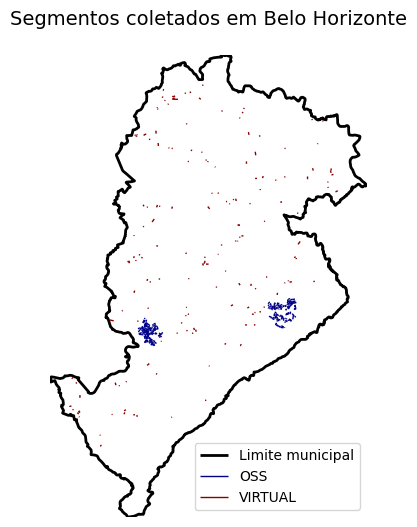

In [11]:
# Plot segmentos

if df["geometry"].dtype == object:
    try:
        df["geometry"] = df["geometry"].apply(wkt.loads)
    except Exception:
        pass

df = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

gdf_bh = ox.geocode_to_gdf("Belo Horizonte, Brazil")

fig, ax = plt.subplots(figsize=(5, 6))

gdf_bh.boundary.plot(ax=ax, edgecolor="black", linewidth=2, label="Limite municipal")

colors = {"oss": "darkblue", "virtual": "darkred"}

for tipo, cor in colors.items():
    subset = df[df["field"] == tipo]
    if not subset.empty:
        subset.plot(ax=ax, color=cor, linewidth=1, alpha=1, label=tipo.upper())

xmin, ymin, xmax, ymax = gdf_bh.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_title("Segmentos coletados em Belo Horizonte\n", fontsize=14)
ax.axis("off")
ax.legend(loc="lower right")

plt.show()

In [12]:
# Coordenada média

# Separar coordenadas em latitude e longitude
df[['lat1', 'lon1']] = df['coordenadas_inicio'].str.split(', ', expand=True).astype(float)
df[['lat2', 'lon2']] = df['coordenadas_termino'].str.split(', ', expand=True).astype(float)

# Calcular ponto médio
df['lat_medio'] = (df['lat1'] + df['lat2']) / 2
df['lon_medio'] = (df['lon1'] + df['lon2']) / 2

# Combinar lat/lon em formato string
df['coordenadas_media'] = df['lat_medio'].astype(str) + ', ' + df['lon_medio'].astype(str)

# Função para converter string em Point (Shapely)
def str_para_point(coord):
    lat, lon = map(float, coord.split(', '))
    return Point(lon, lat)

# Criar geometria do ponto médio
df['geometry_point'] = df['coordenadas_media'].apply(str_para_point)
gdf_pontos = gpd.GeoDataFrame(df.copy(), geometry='geometry_point', crs='EPSG:4326')

# Excluir variáveis
df = df.drop(columns=[col for col in ['lat1', 'lon1', 'lat2', 'lon2', 'lat_medio', 'lon_medio'] if col in df.columns])

# Reorganizar colunas
df = move_column(df, "coordenadas_media", "field")
df = move_column(df, "coordenadas_inicio_2", "coordenadas_termino")
df = move_column(df, "coordenadas_termino_2", "coordenadas_inicio_2")
df = move_column(df, "wkt", "coordenadas_termino_2")

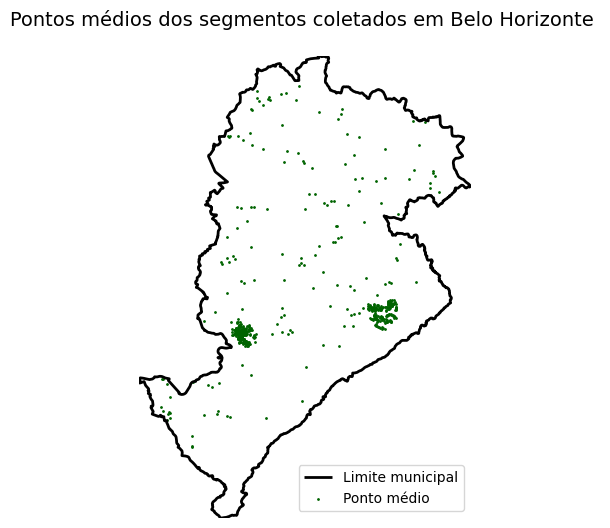

In [13]:
# Plot ponto médio

df = gpd.GeoDataFrame(df, geometry="geometry_point", crs="EPSG:4326")

gdf_bh = ox.geocode_to_gdf("Belo Horizonte, Brazil")

fig, ax = plt.subplots(figsize=(5, 6))

gdf_bh.boundary.plot(ax=ax, edgecolor="black", linewidth=2, label="Limite municipal")

gdf_pontos.plot(ax=ax, color='darkgreen', markersize=1, label="Ponto médio")

xmin, ymin, xmax, ymax = gdf_bh.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_title("Pontos médios dos segmentos coletados em Belo Horizonte \n", fontsize=14)
ax.axis("off")
ax.legend(loc="lower right")

plt.show()

In [14]:
# Selecionar as variáveis de interesse
df_export = df[["id", "field", "coordenadas_media"]]

# Salvar no Excel
df_export.to_excel("coordinates.xlsx", index=False, sheet_name="segments")